<a href="https://colab.research.google.com/github/EricaAndreose/enoam_doc/blob/main/Generate_doc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import rdflib
from datetime import datetime
from rdflib import URIRef, Namespace, Literal
from rdflib.namespace import RDF, RDFS, DCTERMS, FOAF, XSD, SKOS, OWL
from lib.location3 import get_coordinates, normalize_location
import os

Importazione librerie:

1. **rdflib**: libreria Python per lavorare con grafi RDF.
2. **datetime**: modulo Python utilizzato per lavorare con date e orari.
3. **rdflib** (URIRef, rdflib.Namespace, rdflib.Literal): specifici costrutti di RDFLib per lavorare rispettivamente con URI, namespace e valori letterali.
4. **rdflib.namespace.RDF, rdflib.namespace.RDFS, rdflib.namespace.DCTERMS, rdflib.namespace.FOAF, rdflib.namespace.XSD, rdflib.namespace.SKOS, rdflib.namespace.OWL**: namespace standard per l'RDF, ciascuno utilizzato per rappresentare diversi tipi di dati e metadati. Vediamoli nel dettaglio:
  * **RDF**: RDF Schema, utilizzato per descrivere risorse e le loro proprietà.

  * **RDFS**: estensione di RDF per fornire vocabolari più ricchi.
  * **DCTERMS**: Dublin Core Terms, un set di termini utilizzati per descrivere le risorse.
  * **FOAF**: Friend of a Friend, un vocabolario RDF per descrivere persone, le loro relazioni e i loro luoghi.
  * **XSD**: XML Schema Definition, usato per definire tipi di dati.
  * **SKOS**: Simple Knowledge Organization System, utilizzato per la rappresentazione dei thesauri.
  * **OWL**: Web Ontology Language, utilizzato per definire ontologie.

5. **os**: modulo standard di Python utilizzato per interagire con il sistema operativo, ad esempio per lavorare con file, directory e variabili d'ambiente.

Vengono inoltre importate funzioni da un modulo locale:

`get_coordinates` e `normalize_location` sono due funzioni importate dal modulo **lib.location3**.

In [ ]:
# ADD MAIN FRBR STATEMENTS (FRBR entities, relations between them, labels)
def add_frbr(g, document, work, expression, manifestation, fabio, frbr):
    g.add((work, RDF.type, fabio.Work))
    g.add((expression, RDF.type, fabio.Expression))
    g.add((manifestation, RDF.type, fabio.Manifestation))
    g.add((work, RDFS.label, Literal(f'{document["title"]} (FRBR Work)', datatype=XSD.string)))
    g.add((work, frbr.realization, expression))
    g.add((work, fabio.hasManifestation, manifestation))
    g.add((expression, frbr.embodiment, manifestation))
    g.add((expression, RDFS.label, Literal(f'{document["title"]} (FRBR Expression)', datatype=XSD.string)))
    g.add((manifestation, RDFS.label, Literal(f'{document["title"]} (FRBR Manifestation)', datatype=XSD.string)))


La funzione `add_frbr` aggiunge triple RDF al grafo g per rappresentare entità e relazioni basate sul modello FRBR (Functional Requirements for Bibliographic Records).

Questo modello è utilizzato per descrivere la struttura concettuale di opere bibliografiche, e la funzione in questione si occupa di creare e collegare le entità principali del modello: Work, Expression e Manifestation.

La funzione prende in input:

- **g**: un oggetto Graph di RDFLib che rappresenta il grafo RDF in cui verranno aggiunte le dichiarazioni.

- **document**: metadati contenuti su MongoDB in formato dizionario.

- **work, expression, manifestation**: URIRef che rappresentano le entità Work, Expression e Manifestation nel grafo RDF.

- **fabio**: namespace che contiene classi e proprietà del modello FaBiO (FRBR-aligned Bibliographic Ontology), utilizzato per estendere FRBR.

- **frbr**: namespace che contiene le relazioni standard del modello FRBR.

La funzione aggiunge al grafo `g` le triplette che definiscono le tipologie RDF delle entità:

- **work** come un'istanza della classe `fabio.Work`.

- **expression** come un'istanza della classe `fabio.Expression`.

- **manifestation** come un'istanza della classe `fabio.Manifestation`.

Ogni entità (work, expression, manifestation) riceve un'etichetta (**RDFS.label**) che descrive il tipo di entità e include il titolo del documento.

Creazione delle relazioni tra le entità:

**work** è collegato a **expression** tramite la proprietà `frbr.realization`, indicando che expression è una realizzazione di work.

**work** è collegato a **manifestation** tramite la proprietà `fabio.hasManifestation`, indicando che manifestation è una manifestazione di work.

**expression** è collegato a **manifestation** tramite la proprietà `frbr.embodiment`, indicando che manifestation è l'embodiment di expression.



In [ ]:
# ADD IDENTIFIER AS DOI
def add_ident(g, value, manifestation):
    g.add((manifestation, DCTERMS.identifier, Literal(f'10.48678/unibo/aldomoro{".".join(value.split("_"))}', datatype=XSD.string)))


# ADD TITLE
def add_title(g, value, work):
    g.add((work, DCTERMS.title, Literal(value, datatype=XSD.string)))


# ADD CREATOR
def add_creator(g, work, moro):
    g.add((work, DCTERMS.creator, moro))


# ADD CURATOR
def add_contributor(g, value, expression, dataset_ns):
    curator = URIRef(f'{dataset_ns}{value.replace(" ", "-").lower()}')
    g.add((curator, RDF.type, FOAF.Person))
    g.add((curator, RDFS.label, Literal(value, datatype=XSD.string)))
    g.add((expression, DCTERMS.contributor, curator))


# ADD ABSTRACT
def add_abstract(g, value, expression):
    g.add((expression, DCTERMS.abstract, Literal(value, datatype=XSD.string)))

Descriviamo queste funzioni:

1. `add_ident`:aggiunge un identificatore (in questo caso un DOI) all'entità manifestation nel grafo RDF. Il DOI viene creato concatenando il prefisso 10.48678/unibo/aldomoro con la stringa derivata da `value` (input del metadato `ident` di MongoDB), dove gli underscore (_) vengono sostituiti da punti (.).
La tripla risultante associa il DOI alla manifestation tramite la proprietà `DCTERMS.identifier`.

2. `add_title`:aggiunge un titolo all'entità work nel grafo RDF. La tripla risultante associa il titolo (sempre derivante da MongoDB) all'entità work utilizzando la proprietà `DCTERMS.title`.

3. `add_creator`:associa un creatore (autore) all'entità work nel grafo RDF. La tripla risultante associa l'autore (Aldo Moro risulta sempre come autore) all'entità work tramite la proprietà `DCTERMS.creator`.

4. `add_contributor`:aggiunge un curatore come contributore all'entità expression nel grafo RDF. Viene creato un URI per il curatore basato sullo spazio dei nomi `dataset_ns` e sul valore normalizzato di `value` (convertendo gli spazi in trattini e passando tutto in minuscolo). Il curatore viene dichiarato come un'istanza di `FOAF.Person`, e viene anche aggiunta un'etichetta (label) con il nome del curatore come Literal. Infine, la tripla risultante associa il curatore all'entità expression tramite la proprietà `DCTERMS.contributor`.

5. `add_abstract`:aggiunge un abstract all'entità expression nel grafo RDF. La tripla risultante associa l'abstract (sempre derivante dai metadati di MongoDB) all'entità expression tramite la proprietà` DCTERMS.abstract`.

In [ ]:
# ADD ROLES
def add_roles(g, value, mrv, pro, work, moro, tvc, ti, dataset_ns):
    for role in value:
        role = role.replace('.', '')
        role_in_time = URIRef(f'{dataset_ns}role-in-time-{role[-2:]}')
        g.add((moro, pro.holdsRoleInTime, role_in_time))
        role = URIRef(mrv + role)
        g.add((role_in_time, RDF.type, pro.RoleInTime))
        g.add((role_in_time, RDFS.label, Literal(f'Situazione in cui Aldo Moro ricopre il ruolo {role}', datatype=XSD.string)))
        g.add((role_in_time, pro.withRole, role))
        g.add((role_in_time, pro.relatesTo, work))

        time_interval_2 = False
        time_interval_3 = False
        time_interval_4 = False
        time_interval_5 = False

        if role_in_time[-2:] == '01':
            time_start = '1932-07-19'
            time_end = '1933-02-01'
        elif role_in_time[-2:] == '02':
            time_start = '1934-11-01'
            time_end = '1938-11-13'
        elif role_in_time[-2:] == '03':
            time_start = '1934-09-01'
            time_end = '1978-05-09'
        elif role_in_time[-2:] == '04':
            time_start = '1937-03-21'
            time_end = '1939-05-16'
        elif role_in_time[-2:] == '05':
            time_start = '1938-11-18'
            time_end = '1939-10-31'
        elif role_in_time[-2:] == '06':
            time_start = '1939-05-16'
            time_end = '1942-02-10'
        elif role_in_time[-2:] == '07':
            time_start = '1940-11-01'
            time_end = '1963-10-31'
        elif role_in_time[-2:] == '08':
            time_start = '1942-03-01'
            time_end = '1945-12-01'
        elif role_in_time[-2:] == '09':
            time_start = '1943-10-01'
            time_end = '1944-01-31'
        elif role_in_time[-2:] == '10':
            time_start = '1943-11-23'
            time_end = '1978-05-09'
        elif role_in_time[-2:] == '11':
            time_start = '1944-01-01'
            time_end = '1944-06-01'
        elif role_in_time[-2:] == '12':
            time_start = '1945-12-13'
            time_end = '1946-06-02'
        elif role_in_time[-2:] == '13':
            time_start = '1945-12-13'
            time_end = '1948-12-01'
        elif role_in_time[-2:] == '14':
            time_start = '1946-06-25'
            time_end = '1948-01-31'
        elif role_in_time[-2:] == '15':
            time_start = '1947-07-24'
            time_end = '1948-01-31'
        elif role_in_time[-2:] == '16':
            time_start = '1948-05-08'
            time_end = '1978-05-09'
        elif role_in_time[-2:] == '17':
            time_start = '1948-05-27'
            time_end = '1950-01-27'
        elif role_in_time[-2:] == '18':
            time_start = '1948-01-01'
            time_end = '1978-05-09'
        elif role_in_time[-2:] == '19':
            time_start = '1951-11-01'
            time_end = '1959-03-17'
        elif role_in_time[-2:] == '20':
            time_start = '1948-03-30'
            time_end = '1963-11-01'
        elif role_in_time[-2:] == '21':
            time_start = '1963-11-01'
            time_end = '1978-05-09'
        elif role_in_time[-2:] == '22':
            time_start = '1952-09-25'
            time_end = '1952-12-18'
        elif role_in_time[-2:] == '23':
            time_start = '1953-01-01'
            time_end = '1955-01-01'
        elif role_in_time[-2:] == '24':
            time_start = '1955-07-06'
            time_end = '1957-05-19'
            time_start_2 = '1957-05-20'
            time_end_2 = '1959-02-15'
            time_interval_2 = URIRef(f'{dataset_ns}{time_start_2 + "T00:00:00Z"}-{time_end_2 + "T23:59:59Z"}')
        elif role_in_time[-2:] == '25':
            time_start = '1949-12-01'
            time_end = '1978-05-09'
        elif role_in_time[-2:] == '26':
            time_start = '1957-05-19'
            time_end = '1978-05-09'
        elif role_in_time[-2:] == '27':
            time_start = '1959-02-01'
            time_end = '1963-12-01'
        elif role_in_time[-2:] == '28':
            time_start = '1963-12-04'
            time_end = '1964-07-22'
            time_start_2 = '1964-07-22'
            time_end_2 = '1966-02-23'
            time_interval_2 = URIRef(f'{dataset_ns}{time_start_2 + "T00:00:00Z"}-{time_end_2 + "T23:59:59Z"}') #ERICA: i've added the Thours part to fix the ISODATE error
            time_start_3 = '1966-02-23'
            time_end_3 = '1968-06-24'
            time_interval_3 = URIRef(f'{dataset_ns}{time_start_3 + "T00:00:00Z"}-{time_end_3 + "T23:59:59Z"}') #ERICA: i've added the Thours part to fix the ISODATE error
            time_start_4 = '1974-11-23'
            time_end_4 = '1976-02-12'
            time_interval_4 = URIRef(f'{dataset_ns}{time_start_4 + "T00:00:00Z"}-{time_end_4 + "T23:59:59Z"}') #ERICA: i've added the Thours part to fix the ISODATE error
            time_start_5 = '1976-02-12'
            time_end_5 = '1976-07-29'
            time_interval_5 = URIRef(f'{dataset_ns}{time_start_5 + "T00:00:00Z"}-{time_end_5 + "T23:59:59Z"}') #ERICA: i've added the Thours part to fix the ISODATE error
        elif role_in_time[-2:] == '29':
            time_start = '1968-06-05'
            time_end = '1968-06-25'
        elif role_in_time[-2:] == '30':
            time_start = '1964-12-28'
            time_end = '1965-03-05'
            time_start_2 = '1965-12-30'
            time_end_2 = '1966-02-23'
            time_interval_2 = URIRef(f'{dataset_ns}{time_start_2 + "T00:00:00Z"}-{time_end_2 + "T23:59:59Z"}') #ERICA: i've added the Thours part to fix the ISODATE error
            time_start_3 = '1969-08-05'
            time_end_3 = '1972-06-26'
            time_interval_3 = URIRef(f'{dataset_ns}{time_start_3 + "T00:00:00Z"}-{time_end_3 + "T23:59:59Z"}') #ERICA: i've added the Thours part to fix the ISODATE error
            time_start_4 = '1973-07-07'
            time_end_4 = '1974-11-23'
            time_interval_4 = URIRef(f'{dataset_ns}{time_start_4 + "T00:00:00Z"}-{time_end_4 + "T23:59:59Z"}') #ERICA: i've added the Thours part to fix the ISODATE error
        elif role_in_time[-2:] == '31':
            time_start = '1972-07-12'
            time_end = '1973-07-07'
        elif role_in_time[-2:] == '32':
            time_start = '1975-07-01'
            time_end = '1975-12-01'
        elif role_in_time[-2:] == '33':
            time_start = '1976-10-01'
            time_end = '1978-06-09'

        # time_start = datetime.strptime(time_start, "%Y-%m-%d").strftime("%d-%m-%Y")
        # time_end = datetime.strptime(time_end, "%Y-%m-%d").strftime("%d-%m-%Y")


        time_start = time_start + "T00:00:00Z" #ERICA: i've added the Thours part to fix the ISODATE error
        time_end = time_end + "T23:59:59Z" #ERICA: i've added the Thours part to fix the ISODATE error

        time_start_ok = datetime.strptime(time_start, "%Y-%m-%dT%H:%M:%SZ").strftime("%d-%m-%YT%H:%M:%SZ") #ERICA: i've added the Thours part to fix the ISODATE error
        time_end_ok = datetime.strptime(time_end, "%Y-%m-%dT%H:%M:%SZ").strftime("%d-%m-%YT%H:%M:%SZ") #ERICA: i've added the Thours part to fix the ISODATE error

        time_interval = URIRef(f'{dataset_ns}{time_start_ok}-{time_end_ok}')
        g.add((time_interval, RDF.type, ti.TimeInterval))
        g.add((time_interval, ti.hasIntervalStartDate, Literal(time_start_ok, datatype=XSD.dateTime)))
        g.add((time_interval, ti.hasIntervalEndDate, Literal(time_end_ok, datatype=XSD.dateTime)))
        g.add((role_in_time, tvc.inTime, time_interval))


        if time_interval_2:

            # time_start_2 = datetime.strptime(time_start_2, "%Y-%m-%d").strftime("%d-%m-%Y")
            # time_end_2 = datetime.strptime(time_end_2, "%Y-%m-%d").strftime("%d-%m-%Y")

            time_start_2 = time_start_2 + "T00:00:00Z"
            time_end_2 = time_end_2 + "T23:59:59Z"

            time_start_2ok = datetime.strptime(time_start_2, "%Y-%m-%dT%H:%M:%SZ").strftime("%d-%m-%YT%H:%M:%SZ")
            time_end_2ok = datetime.strptime(time_end_2, "%Y-%m-%dT%H:%M:%SZ").strftime("%d-%m-%YT%H:%M:%SZ")

            g.add((time_interval_2, RDF.type, ti.TimeInterval))
            g.add((time_interval_2, ti.hasIntervalStartDate, Literal(time_start_2ok, datatype=XSD.dateTime)))
            g.add((time_interval_2, ti.hasIntervalEndDate, Literal(time_end_2ok, datatype=XSD.dateTime)))
            g.add((role_in_time, tvc.inTime, time_interval_2))

        if time_interval_3:

            # time_start_3 = datetime.strptime(time_start_3, "%Y-%m-%d").strftime("%d-%m-%Y")
            # time_end_3 = datetime.strptime(time_end_3, "%Y-%m-%d").strftime("%d-%m-%Y")

            time_start_3 = time_start_3 + "T00:00:00Z"
            time_end_3 = time_end_3 + "T23:59:59Z"

            time_start_3ok = datetime.strptime(time_start_3, "%Y-%m-%dT%H:%M:%SZ").strftime("%d-%m-%YT%H:%M:%SZ")
            time_end_3ok = datetime.strptime(time_end_3, "%Y-%m-%dT%H:%M:%SZ").strftime("%d-%m-%YT%H:%M:%SZ")

            g.add((time_interval_3, RDF.type, ti.TimeInterval))
            g.add((time_interval_3, ti.hasIntervalStartDate, Literal(time_start_3ok, datatype=XSD.dateTime)))
            g.add((time_interval_3, ti.hasIntervalEndDate, Literal(time_end_3ok, datatype=XSD.dateTime)))
            g.add((role_in_time, tvc.inTime, time_interval_3))

        if time_interval_4:

            # time_start_4 = datetime.strptime(time_start_4, "%Y-%m-%d").strftime("%d-%m-%Y")
            # time_end_4 = datetime.strptime(time_end_4, "%Y-%m-%d").strftime("%d-%m-%Y")

            time_start_4 = time_start_4 + "T00:00:00Z"
            time_end_4 = time_end_4 + "T23:59:59Z"

            time_start_4ok = datetime.strptime(time_start_4, "%Y-%m-%dT%H:%M:%SZ").strftime("%d-%m-%YT%H:%M:%SZ")
            time_end_4ok = datetime.strptime(time_end_4, "%Y-%m-%dT%H:%M:%SZ").strftime("%d-%m-%YT%H:%M:%SZ")


            g.add((time_interval_4, RDF.type, ti.TimeInterval))
            g.add((time_interval_4, ti.hasIntervalStartDate, Literal(time_start_4ok, datatype=XSD.dateTime)))
            g.add((time_interval_4, ti.hasIntervalEndDate, Literal(time_end_4ok, datatype=XSD.dateTime)))
            g.add((role_in_time, tvc.inTime, time_interval_4))

        if time_interval_5:

            # time_start_5 = datetime.strptime(time_start_5, "%Y-%m-%d").strftime("%d-%m-%Y")
            # time_end_5 = datetime.strptime(time_end_5, "%Y-%m-%d").strftime("%d-%m-%Y")

            time_start_5 = time_start_5 + "T00:00:00Z"
            time_end_5 = time_end_5 + "T23:59:59Z"

            time_start_5ok = datetime.strptime(time_start_5, "%Y-%m-%dT%H:%M:%SZ").strftime("%d-%m-%YT%H:%M:%SZ")
            time_end_5ok = datetime.strptime(time_end_5, "%Y-%m-%dT%H:%M:%SZ").strftime("%d-%m-%YT%H:%M:%SZ")

            g.add((time_interval_5, RDF.type, ti.TimeInterval))
            g.add((time_interval_5, ti.hasIntervalStartDate, Literal(time_start_5ok, datatype=XSD.dateTime)))
            g.add((time_interval_5, ti.hasIntervalEndDate, Literal(time_end_5ok, datatype=XSD.dateTime)))
            g.add((role_in_time, tvc.inTime, time_interval_5))


La funzione `add_roles` aggiunge ruoli temporali, e gli intervalli di tempo corrispondenti, associati ad Aldo Moro nel grafo RDF. Ogni ruolo è associato a un intervallo di tempo specifico, durante il quale Moro ha svolto un determinato ruolo. La funzione gestisce anche casi in cui ci sono più intervalli di tempo per lo stesso ruolo.

**Iterazione sui Ruoli**:

La funzione itera su una lista di ruoli (presi dai metadati presenti su MongoDB). Per ogni ruolo, esegue i seguenti passaggi:

1. Normalizza il ruolo rimuovendo eventuali punti (.).
2. Crea un URI per rappresentare l'entità "role in time" specifica al ruolo corrente, utilizzando il suffisso del ruolo per l'URI.
3. Associa il ruolo a Aldo Moro nel grafo RDF, utilizzando il concetto `pro.holdsRoleInTime`.

**Creazione dell'Entità Role In Time**:

Viene creato un URI per rappresentare il ruolo specifico, utilizzando il namespace `mrv`.
La funzione aggiunge informazioni sul ruolo, inclusa un'etichetta che descrive il ruolo temporale, e collega il ruolo all'opera (work) a cui è correlato.

**Intervalli di Tempo**:

A seconda del ruolo, la funzione identifica un intervallo di tempo specifico utilizzando una serie di condizioni if. Gli intervalli di tempo sono definiti in base ai suffissi del ruolo (`role_in_time[-2:]`).
Se un ruolo ha più intervalli di tempo, la funzione gestisce ciascun intervallo separatamente, creando entità `TimeInterval` per ciascun periodo e collegandole al ruolo temporale.
La funzione aggiunge anche le date di inizio e fine per ogni intervallo di tempo, assicurandosi che le date siano nel formato corretto (YYYY-MM-DDTHH:MM:SSZ). Il formato è stato integrato dopo un'aggiornamento avvenuto sul parametro ISODATE in python.

**Creazione delle Entità TimeInterval**:

Per ogni intervallo di tempo identificato, viene creata un'entità `TimeInterval` con un URI specifico che rappresenta l'intervallo.
Vengono aggiunte informazioni sul tipo (`RDF.type`) e sulle date di inizio e fine dell'intervallo (`ti.hasIntervalStartDate` e `ti.hasIntervalEndDate`).
Ogni `TimeInterval` è poi associato al ruolo temporale pertinente tramite la proprietà `tvc.inTime`.


In [ ]:
# ADD DOCUMENT TYPES
def add_types(g, value, mtv, expression):
    for doctype in value:
        doctype = doctype.replace('.', '')[3:]
        doctype = URIRef(mtv + doctype)
        g.add((expression, DCTERMS.type, doctype))


# ADD DOCUMENT SUBJECTS
def add_subjects(g, value, msv, work):
    for subject in value:
        subject = subject.replace('doctopic.', 'subject')
        subject = URIRef(msv + subject)
        g.add((work, DCTERMS.subject, subject))

Le due funzioni qui sopra creano due triple descrittive riguardanti la *tipologia* del documento e i principali *topic* trattati nel documento.
Ricordo che tutte queste informazioni vengono salvate su MongoDB su input delle scelte dei ricercatori effettuate all'interno del *form compilativo sui metadati* presente su KwicKwocKwac. Su MongoDB, in questo caso specifico, le finrmazioni vengono salvate all'interno delle chiavi **doctypeList** e **doctopicList**. Queste chiavi sono degli array e possono contenere più di un valore. In questi due casi i valori vengono salvati come numeri interi che rispecchiano la specifica tipologia o topic del documento che il ricercatore seleziona all'interno delle liste a cascata del form su Kwic. Ogni numero corrisponde, in ordine crescende, ad una delle stringhe della lista. (Es. `doctypeList: doctype.08` corrisponde a "*Intervento istituzionale*" - `doctopicList: doctopic.06` corrisponde a "*Politica internazionale*").

Vedasi immagini allegate rappresentanti il form presente su KwicKwicKwac per la scelta della tipologia del documento e il corrispettivo metadato salvato nel dizionario di MongoDB.
Per risolvere o correggere eventuali errori generati su questi passaggi è fondamentale capire i passaggi tra un software e l'altro.

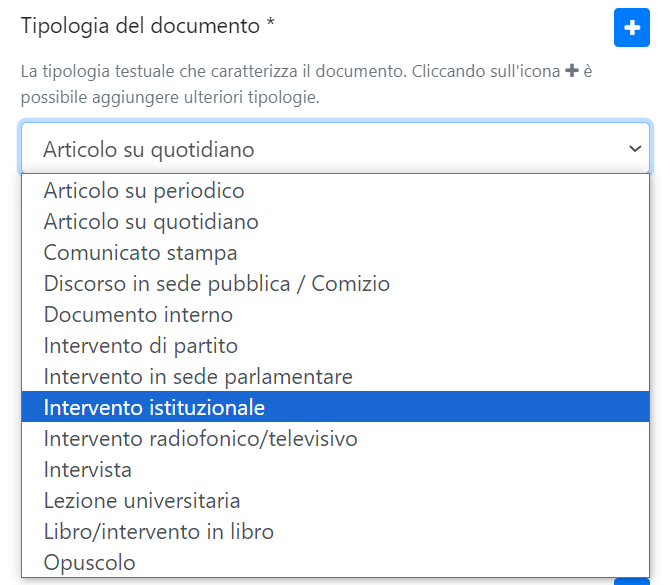
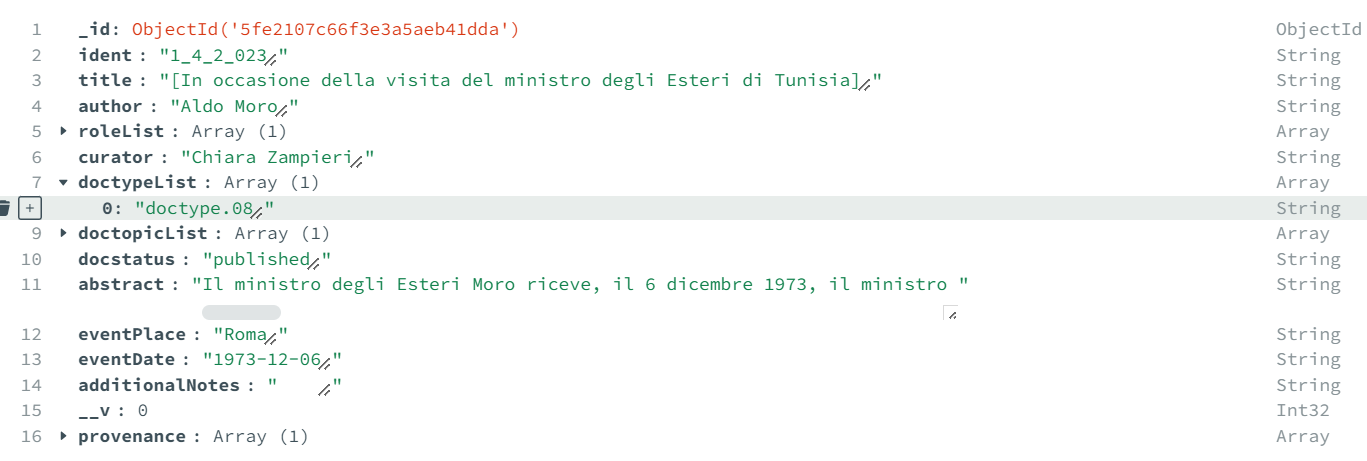

In [ ]:
# ADD SPATIAL COVERAGE
def add_spatial(g, value, expression, dataset_ns):

    geonames = Namespace('http://www.geonames.org/ontology#')
    wgs84_pos = Namespace('http://www.w3.org/2003/01/geo/wgs84_pos#')
    g.bind('geonames', geonames)
    g.bind('wgs84_pos', wgs84_pos)

    place_text = value.lower()
    place = URIRef(f'{dataset_ns}{value.replace(" ", "-").lower()}')
    g.add((place, RDF.type, DCTERMS.Location))
    g.add((place, RDFS.label, Literal(value, datatype=XSD.string)))
    g.add((expression, DCTERMS.spatial, place))

    if place:

        normalize = normalize_location(place_text)
        coordinates = get_coordinates(normalize)

        if coordinates:


            long = coordinates[0]
            lat = coordinates[1]
            key = coordinates[2]

            g.add((place, wgs84_pos.lat, Literal(lat)))
            g.add((place, wgs84_pos.long, Literal(long)))
            g.add((place, geonames.featureClass, geonames[key]))


La funzione `add_spatial` inserisce nel grafo delle triple per la descrizione e la georeferenziazione dei luoghi menzionati nei metadati.
L'input `value` corrisponde infatti al valore della chiave `eventPlace` presente nel dizionario di MongoDB.

Come primo step la stringa corrispondente al nome del luogo viene pulita e uniformata, vengono poi create tre triple descrittive che menzionano cosa stiamo descrivendo (un `DCTERMS.Location`), che label associargli e che tipo di expression è.

Successivamente vengono importare le due funzioni esterne `normalize_location` e `get_coordinates`.
Tramite queste è possibile risalire alle coordinate di latitudine e longitudine del luogo menzionato. Queste informazioni vengono quindi inserite come triple nel grafo.

Grazie a queste informazioni (inserite esattamente con questa formazione) è possibile la comunicazione tra il nostro file "*dataset.ttl*" finale e la mappa interattiva presente nel sito nella sezione "**Gli indici analitici**" -> "**Luoghi**", dove vengono visualizzati tutti i luoghi menzionati all'interno dell'edizione digitale.


